# Importation des bibliothéques

## Remarques
 * Dropout : 
             met à 0 la valeur de certains neuronne de façon aléatoire à 
             chaque passe de sorte à éviter la codépendance
 * Flatten : 
             sert à transformet le tensor de nos images en veteurs simples 
             à la suite de la conolution
             
             

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , Activation , Flatten , Conv2D ,MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import os
import pickle
import numpy as np
import cv2
import time

#Nommer le model
création d'une variable nom ayant pour but de géner un nouveau nom pour chaque model que l'on compte sauvegarder

In [0]:
Nom = "CNN-classifaction-Radio-{}".format(int(time.time()))

#Charger notre Drive

In [0]:
# Exécutez cette cellule pour installer votre Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#le chemain vers les fichiers est le suivant
%cd drive/My Drive/Colab Notebooks/my_models/dataset175
%pwd
%ls

/content/drive/My Drive/Colab Notebooks/my_models/dataset175
CNN/      etiquettes.pickle  logs/  SAVC/                t_images.pickle
CNNplus/  images.pickle      SAV/   t_etiquettes.pickle


#Sauvegarde du model obtenu

la fonction save sauvegarde l'architecture , les poids apres entrainement et les paramétres d'entrainement du model

ce qui permet de reprendre l'entrainement au besoin

In [0]:
path = "./CNNplus"
sav_rep = os.path.dirname(path)

# Create checkpoint callback
save = tf.keras.callbacks.ModelCheckpoint(       sav_rep,
                                                 save_weights_only=True,
                                                 verbose=1)


# Ajout du moniteur de controle TensorBoard

In [0]:
# indique ou serrons stocké nos versions
tb = TensorBoard(log_dir='.logs/{}'.format(int(time.time())),
                 write_graph= True )

#Limitation des fonctionalitées du GPU

 ici nous précisions que nous utiliserons 33 % du GPU de cette machine , afin de limiter la puissance du GPU à alouer à notre modéle
 

In [0]:
#gpu_op = tf.GPUOptions(per_process_gpu_memory_fraction = 0.7)
#sess = tf.Session(config = tf.ConfigProto(gpu_options = gpu_op))

# chargment du dataset

In [0]:
images_train     = pickle.load(open("images.pickle"    ,"rb"))
etiquettes_train = pickle.load(open("etiquettes.pickle","rb"))

# Normalisation du dataset

  Ayant des images (sous forme de tensor) prétraité (55 X55 X1) en niveaux de gris il nous suffit de diviser les valeurs de chaque pixel (encodées sur 8bits) par 255

In [0]:
images_train = images_train / 255.0

# Construction du model
  
  Nous passons comme paramétre de la couche convolutive :
   * le nombre de neuronnes qui la compose ici 64
   * la taille du filtre qui va parcourir nos images ici (3 , 3)
   * le type de données en entrée ici nous prenons la forme de nos images (avec .shape)
   * la fonction d'activation de cette couche de neuronnes ici relu
  
  Nous faisons ensuite succéder à celle-ci une couche dite de *Pooling* dont le role est de parcourir la matrice résultat envoyé par la couche Convolutive pour ensuite la simplifié en ne gardant (dans notre cas) que la valeure maximale locale du filtre appliqué à la matrice résultat ici cette matrice est de taille (2,2)

In [0]:
#Sequentiel définie le type de model (couches successives)
notre_model = Sequential()
#première couche (une couche de neuronnes convolutifs)
notre_model.add(Conv2D(256, (10, 10), input_shape= images_train.shape[1:]) )
notre_model.add(Activation("relu"))
#ajout d'une couche de dropout
notre_model.add(Dropout(rate = 0.3))
notre_model.add(Conv2D(128, (7,7)))
notre_model.add(Activation("relu"))
notre_model.add(MaxPooling2D(pool_size = (4,4)))
notre_model.add(Conv2D(64, (5,5)))
notre_model.add(Activation("relu"))
#seconde couche (NB: dans le cas des CNN la couche de pooling suit toujours celle de convolution)
notre_model.add(MaxPooling2D(pool_size = (5,5)))
#nous ajoutons au model une seconde couche convolutive similaire à la précédente
#NB : que input_shape n'est plus utilisé car il ne sert quand le cas de l'input layer
notre_model.add(Conv2D(64, (5,5)))
notre_model.add(Activation("relu"))
notre_model.add(MaxPooling2D(pool_size = (3,3)))


W0705 09:11:48.351256 140644232419200 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


 en générale il est conseiller de mettre une( ou plusieurs) couches de neuronnes totalment connéctées dont le role est d'exploiter les tensores transformées en veteurs (en sortie de la phase de convolution) pour aboutir à une classification

In [0]:
#cette couche permet de transoformer notre matrice résultat en un vecteur
notre_model.add(Flatten())
#couche de neuronnes denses
notre_model.add(Dense(64))
notre_model.add(Activation("relu"))
notre_model.add(Dense(16))
notre_model.add(Activation("relu"))
#couche de sortie
notre_model.add(Dense(1))
notre_model.add(Activation("sigmoid"))

# Entrainement et validation du Model

## Entrainement

### paramétrage
  Dans ce qui suit nous allons préciser les paramétres d'entrainement de notre model les plus importants étant 
  
  * Loss :
         ce paramétre indique la fonction utilisée pour calculer l'ecart entre les résultats du model            et les résultats attendus la fonction choisie ici est *binary_crossentropy*
  * Optimizer :
          ce paramétre indique la fonction utilisée pour calculer les nouvelles valeurs des poids ,               biais et paramétres variables de notre modéle ici nous utilisons *adam* (une variaante de GD)
  * Metrics :
          il s'agit de la valeurs que nous souhaitons maitriser et suivre durant cet enentrainement
          ici nous il s'agit de la précision *accuracy*
   

In [0]:
#mean_squared_error
#binary_crossentropy
notre_model.compile(loss      = "mean_squared_error", 
                    optimizer = "adam",
                    metrics   = ['accuracy'])

### resumé des poid de notre reseau couche par couche

In [0]:
notre_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 166, 166, 256)     25856     
_________________________________________________________________
activation (Activation)      (None, 166, 166, 256)     0         
_________________________________________________________________
dropout (Dropout)            (None, 166, 166, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 128)     1605760   
_________________________________________________________________
activation_1 (Activation)    (None, 160, 160, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 64)        2

### lancement de l'entrainement

 ici nous précisions les données en entrée(images_train , etiquettes_train) et le nombre de passes que subirons nos données (epoch) et le nombre de données à traiter avant d'opérer un ajustement des paramétrs (batch_size) et la quantité de données à laisser de coté pour la phase de validation (validation_split)

In [0]:
%cd CNNplus 

/content/drive/My Drive/Colab Notebooks/my_models/dataset175/CNNplus


In [0]:
notre_model.fit(images_train,etiquettes_train ,batch_size = 55 ,epochs = 2 ,validation_split = 0.1,callbacks=[tb,save])

Train on 4708 samples, validate on 524 samples
Epoch 1/2
4675/4708 [============================>.] - ETA: 1s - loss: 0.1935 - acc: 0.7455
Epoch 00001: saving model to .
4708/4708 [==============================] - 174s 37ms/sample - loss: 0.1937 - acc: 0.7462 - val_loss: 0.2157 - val_acc: 0.8473
Epoch 2/2
4675/4708 [============================>.] - ETA: 0s - loss: 0.1396 - acc: 0.8088
Epoch 00002: saving model to .
4708/4708 [==============================] - 139s 29ms/sample - loss: 0.1394 - acc: 0.8090 - val_loss: 0.0871 - val_acc: 0.8798


# Test et validation finale

## importation et pretraitment des données de test






In [0]:
%cd ..
images_test     = pickle.load(open("t_images.pickle"    ,"rb"))
etiquettes_test = pickle.load(open("t_etiquettes.pickle","rb"))
images_test = images_test / 255.0

/content/drive/My Drive/Colab Notebooks/my_models/dataset175


## test et validation

In [0]:
val_loss , val_acc = notre_model.evaluate(images_test , etiquettes_test)

print (" le valeur de Loss est de " , val_loss) 
print (" le valeur de la precision est de ",val_acc) 

624/624 [==============================] - 8s 12ms/sample - loss: 0.1077 - acc: 0.8510
 le valeur de Loss est de  0.10765756819492732
 le valeur de la precision est de  0.85096157


In [0]:
a = notre_model.predict(images_test)

In [0]:
pred = []
for i in a :
  if i > 0.5 :
    pred.append(1)
  else :
    pred.append(0)

In [0]:
print(pred)

[1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(etiquettes_test, pred)
print(cm)

[[174  60]
 [ 33 357]]


In [0]:
sensibilite = cm[1,1] / ( cm[1,1] + cm [1,0] )
print("la sensibilité de notre model est de : ", sensibilite)
specificite = cm[0,0] / ( cm[0,0] + cm[0,1] )
print("la specificité de notre model est de : ", specificite)

la sensibilité de notre model est de :  0.9153846153846154
la specificité de notre model est de :  0.7435897435897436


#Chargement du model sauvegardé

In [0]:
model = Sequential()
model.add(Conv2D(256, (3, 3), input_shape= images_train.shape[1:]) )
model.add(Activation("relu"))
model.add(Dropout(rate = 0.3))
model.add(Conv2D(128, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (4,4)))
model.add(Conv2D(64, (5,5)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (5,5)))
model.add(Conv2D(64, (5,5)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(1))
model.add(Activation("sigmoid"))
model.compile(loss      = "mean_squared_error",
                    optimizer = "adam",
                    metrics   = ['accuracy'])

In [0]:
%cd CNNplus
model.load_weights(".")
loss, acc = model.evaluate(images_test , etiquettes_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

/content/drive/My Drive/Colab Notebooks/my_models/dataset175/CNNplus
624/624 [==============================] - 3s 5ms/sample - loss: 0.1077 - acc: 0.8510
Restored model, accuracy: 85.10%


In [0]:
from google.colab import files
import IPython.display 

In [0]:
im = files.upload()

Saving IM-0001-0001.jpeg to IM-0001-0001 (1).jpeg


In [0]:
import matplotlib.pyplot as plt
import cv2

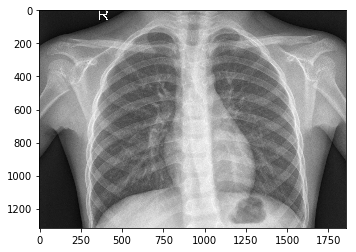

In [0]:
i = cv2.imread('IM-0001-0001 (1).jpeg')
plt.imshow(i,cmap = "gray" )